# Time Series Project

##### Luke Becker, Data Scientist

In [1]:
# Importing libraries and functions for use.
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# splitting data:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import entropy

# web-based requests
import requests
import rapid_env

# Importing the os library specifically for reading the csv once I've created the file in my working directory.
import os

import acquire
import prepare
import env
import rapid_env


# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

Imported env successfully.
credentials loaded successfully
End of acquire.py file.
Loaded all prepare functions.


# Plan

Data source is from Codeup's curriculum logs from January 2018 until October 2020. These logs track income IP addresses which are accessing the website's curriculum and possibly other areas of the website.

#### Objectives:
1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 
5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
7. Which lessons are least accessed? 
8. Anything else I should be aware of? 


### Ideas:
- Try creating continuous variables from my categorical variables.
- Filter down the data to a specific cohort and looking at data that way to hopefully find something useful.
- Use as my attribute a single user id; loop through each user id. Then, *by user* find anomalies with regard to that *individual user*, not to the patterns across *all* users.
- Use this code to help create a categorical variable from continuous variables: `groupby().size() = continuous variable`
- *Nice to have:* to help me visualize, install an ip address library to map out where each ip address is.

## Acquire

In [2]:
df = acquire.get_time_series('anonymized-curriculum-access.txt')
df.head()

,date,timestamp,webpage,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       719459 non-null  object 
 1   timestamp  719459 non-null  object 
 2   webpage    719458 non-null  object 
 3   user_id    719459 non-null  int64  
 4   cohort_id  674619 non-null  float64
 5   ip         719459 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 32.9+ MB


In [4]:
# Importing the Cohort data

In [5]:
# Adding cohort names


cohorts = pd.read_csv('cohorts.csv', index_col = 'cohort_id')
cohorts

,name,start_date,end_date,program_id
cohort_id,,,,
1,Arches,2014-02-04,2014-04-22,1
2,Badlands,2014-06-04,2014-08-22,1
3,Carlsbad,2014-09-04,2014-11-05,1
4,Denali,2014-10-20,2015-01-18,1
5,Everglades,2014-11-18,2015-02-24,1
6,Franklin,2015-02-03,2015-05-26,1
7,Glacier,2015-06-05,2015-10-06,1
8,Hampton,2015-09-22,2016-02-06,1
9,Apollo,2015-03-30,2015-07-29,4


In [ ]:
# Acquire complete.

## Prepare Stage:

- I need to combine the date and timestamp into one column and make it a datetime dtype.
- Drop the old date and time seprate columns.
- Set the new datetime as the index
- Add year, month, day, hour and weekday columns to primary dataframe

In [6]:
df.shape

(719459, 6)

In [7]:
df = prepare.prep_web_project(df)
df.shape

(719459, 10)

In [8]:
df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False


In [ ]:
# Prep Function:

# def prep_web_project(df):
#     '''
#     This function will prepare the dataframe for exploration. 
#     '''
    
#     # Combining the date and time into one column
#     df['date_time'] = df['date'] + " " + df["timestamp"]
#     df['date_time'] = pd.to_datetime(df.date_time)
    
#     # Dropping old columns:
#     df.drop(columns = ['date', 'timestamp'], inplace = True)
    
#     # Now to set that dt as the index:
#     df = df.set_index('date_time')
    
#     # Adding columns for future analysis and exploration:
    
#     df['year'] = df.index.year
#     df['month'] = df.index.month
#     df['day'] = df.index.day
#     df['hour'] = df.index.hour
#     df['weekday'] = df.index.day_name()
    
#     return df
    

In [ ]:
# Creating cohort type mask; ds vs. webdev:

# cohorts['is_ds'] = cohorts.program_id == 3

In [9]:
cohorts.head()

,name,start_date,end_date,program_id
cohort_id,,,,
1,Arches,2014-02-04,2014-04-22,1
2,Badlands,2014-06-04,2014-08-22,1
3,Carlsbad,2014-09-04,2014-11-05,1
4,Denali,2014-10-20,2015-01-18,1
5,Everglades,2014-11-18,2015-02-24,1


In [121]:
df['date'] = df.index
df

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,date
date_time,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:06
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:24
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,2020-11-02 16:48:13
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,2020-11-02 16:48:17
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,2020-11-02 16:48:18


In [11]:
df['is_ds'] = df.cohort_id.isin([30, 34, 55, 59])

In [193]:
df_merge = pd.merge(df, cohorts, on = 'cohort_id')
df_merge.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,date,name,start_date,end_date,program_id
0,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:55:03,Hampton,2015-09-22,2016-02-06,1
1,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:02,Hampton,2015-09-22,2016-02-06,1
2,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:05,Hampton,2015-09-22,2016-02-06,1
3,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:06,Hampton,2015-09-22,2016-02-06,1
4,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,2018-01-26 10:40:15,Hampton,2015-09-22,2016-02-06,1


In [194]:
df_merge.set_index('date', inplace = True)

In [196]:
df_merge.start_date = pd.to_datetime(df_merge.start_date)
df_merge.end_date = pd.to_datetime(df_merge.end_date)

In [198]:
mask = ((df_merge.index > df_merge['start_date']) & (df_merge.index <= df_merge['end_date']))

In [199]:
df_merge['is_active'] = mask

In [200]:
df_merge

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True


In [ ]:
# I should probably also add a counter column like this:
# df[pageviews] == 1

In [202]:
df_merge2 = df_merge.copy()

In [185]:
df_merge = df_merge[df_merge.webpage != "/"]
df_merge = df_merge[df_merge.webpage.str.contains("github.com") != True]
df_merge = df_merge[df_merge.webpage.str.contains("jpeg")!= True]
df_merge = df_merge[df_merge.webpage.str.contains("jpg")!= True]
df_merge = df_merge[df_merge.webpage.str.contains("svg")!= True]
df_merge = df_merge[df_merge.webpage.str.contains("toc")!= True]
df_merge = df_merge[df_merge.webpage.str.contains(".gitignore")!= True]
df_merge = df_merge[df_merge.webpage.str.contains(".git")!= True]
df_merge = df_merge[df_merge.webpage.str.contains("json")!= True]
df_merge = df_merge[df_merge.webpage.str.contains("wp-login")!= True]
df_merge

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 11:26:13,java-i,1,8.0,97.105.19.61,2018,1,26,11,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True


### Data Science dataframe

In [13]:
# Data science dataframe
ds_df = df.copy()
ds_df = ds_df[df.cohort_id.isin([30, 34, 55, 59])]
ds_df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:39:59,/,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:39:59,/,468,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:02,/,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:08,/,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True


In [14]:
ds_df = ds_df[ds_df.webpage != "/"]
ds_df = ds_df[ds_df.webpage.str.contains("github.com") != True]
ds_df = ds_df[ds_df.webpage.str.contains("jpeg")!= True]
ds_df = ds_df[ds_df.webpage.str.contains("jpg")!= True]
ds_df = ds_df[ds_df.webpage.str.contains("svg")!= True]
ds_df = ds_df[ds_df.webpage.str.contains("toc")!= True]
ds_df = ds_df[ds_df.webpage.str.contains(".gitignore")!= True]
ds_df = ds_df[ds_df.webpage.str.contains(".git")!= True]
ds_df = ds_df[ds_df.webpage.str.contains("json")!= True]
ds_df = ds_df[ds_df.webpage.str.contains("wp-login")!= True]
ds_df

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
...,...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,2,15,Monday,True


### Creating WebDeb Dataframe:

In [15]:
webdev = df[(~df.cohort_id.isin([30, 34, 55, 59]))]
webdev.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False


In [16]:
webdev = webdev[webdev.webpage != "/"]
webdev = webdev[~webdev.webpage.str.contains("github.com")]
webdev = webdev[~webdev.webpage.str.contains("jpeg")]
webdev = webdev[~webdev.webpage.str.contains("jpg")]
webdev = webdev[~webdev.webpage.str.contains("svg")]
webdev = webdev[~webdev.webpage.str.contains("toc")]
webdev = webdev[~webdev.webpage.str.contains(".gitignore")]
webdev = webdev[~webdev.webpage.str.contains(".git")]
webdev = webdev[~webdev.webpage.str.contains("json")]
webdev = webdev[~webdev.webpage.str.contains("wp-login")]
# webdev.sort_values(by = 'pageviews', ascending = False)

In [ ]:
# This means that my log data starts at part-wary through the Sequoia cohort on.

# Now I also have a categorical variable in the `is_ds` column that I can use later.

In [ ]:
# The above didn't work, simply because I think the cohort ids are out of sync between the two dataframes...
# Maybe the best thing to do is simply use the cohort Ids I already have for now...

## Explore - Answers to Questions


### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

### Most Used pages in webdev:

In [17]:
# Need to clean up rows first:
webdev = webdev.groupby(['webpage'])['user_id'].count()
webdev = webdev.reset_index()

In [18]:
webdev.rename(columns = {'user_id': 'pageviews'}, inplace = True)

In [19]:
webdev.sort_values(by = 'pageviews', ascending = False)

,webpage,pageviews
1478,javascript-i,14541
1460,java-iii,10831
1373,html-css,10788
1447,java-ii,10370
1755,spring,9909
...,...,...
1561,ltc-ml/slides/1,1
923,capsones/151,1
927,capstone/50,1
1558,loguout,1


In [20]:
webdev.shape

(1882, 2)

In [21]:
webdev.sort_values(by = 'pageviews', ascending = False)
webdev.head(25)

,webpage,pageviews
0,00_,9
1,00_index,29
2,01_intro,53
3,02_listing_files,49
4,03_file_paths,49
5,04_navigating_the_filesystem,55
6,05_creating_files_and_directories,76
7,06_moving_files,78
8,07_more_topics,75
9,0_Classification_Algorithms,2


In [22]:
# Removing un-needed rows:

# Can I turn this into a for loop? (Yes, once MVP is done)
webdev = webdev[webdev.webpage != "/"]
webdev = webdev[~webdev.webpage.str.contains("github.com")]
webdev = webdev[~webdev.webpage.str.contains("jpeg")]
webdev = webdev[~webdev.webpage.str.contains("toc")]
webdev = webdev[~webdev.webpage.str.contains(".gitignore")]
webdev = webdev[~webdev.webpage.str.contains(".git")]
webdev = webdev[~webdev.webpage.str.contains("json")]
webdev = webdev[~webdev.webpage.str.contains("wp-login")]
webdev.sort_values(by = 'pageviews', ascending = False)

,webpage,pageviews
1478,javascript-i,14541
1460,java-iii,10831
1373,html-css,10788
1447,java-ii,10370
1755,spring,9909
...,...,...
1561,ltc-ml/slides/1,1
923,capsones/151,1
927,capstone/50,1
1558,loguout,1


In [23]:
webdev.describe()

,pageviews
count,1882.000000
mean,306.242295
std,1134.532599
min,1.000000
25%,2.000000
50%,10.000000
75%,49.000000
max,14541.000000


In [24]:
wd_pop = webdev.sort_values(by = 'pageviews', ascending = False).head(5)

### Webdev most popular pages by page view

- Dataframe and barplot showing the top 5 most popular pages.

In [25]:
wd_pop = wd_pop.reset_index()
wd_pop.drop('index', axis = 'columns', inplace = True)
# wd_pop.drop(columns = "level_0", inplace = True)
wd_pop

,webpage,pageviews
0,javascript-i,14541
1,java-iii,10831
2,html-css,10788
3,java-ii,10370
4,spring,9909


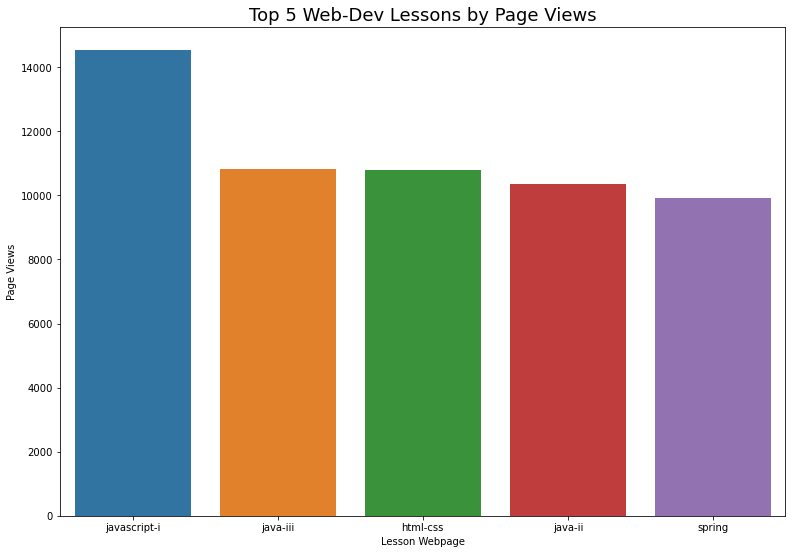

In [26]:
# Plotting the final graph to show top 5 most popular webpages in the webdev program
plt.figure(figsize = (13, 9))
sns.barplot(x = 'webpage', y = 'pageviews', data = wd_pop)
plt.title("Top 5 Web-Dev Lessons by Page Views", fontsize = 18)
plt.ylabel("Page Views")
plt.xlabel("Lesson Webpage")
plt.show()

### Data Science most popular pages by page view

- Dataframe and barplot showing the top 5 most popular pages.

In [27]:
# Need to clean up rows first:
dsdf = ds_df.groupby(['webpage'])['user_id'].count()
dsdf = dsdf.reset_index()

In [28]:
dsdf.rename(columns = {'user_id': 'pageviews'}, inplace = True)

In [29]:
dsdf

,webpage,pageviews
0,1-fundamentals,10
1,1-fundamentals/1.1-intro-to-data-science,1536
2,1-fundamentals/1.2-data-science-pipeline,638
3,1-fundamentals/1.3-pipeline-demo,300
4,1-fundamentals/2.1-excel-overview,187
...,...,...
541,timeseries/sarimax,7
542,timeseries/svr,8
543,timeseries/working-with-time-series-data,86
544,timeseries/working-with-time-series-data-with-...,8


In [30]:
dsdf.sort_values(by = 'pageviews', ascending = False)

,webpage,pageviews
1,1-fundamentals/1.1-intro-to-data-science,1536
174,6-regression/1-overview,1123
346,classification/overview,860
17,10-anomaly-detection/1-overview,742
96,3-sql/1-mysql-overview,704
...,...,...
401,grades/getUserDetails/916/3,1
400,grades,1
399,git/cli,1
255,9-timeseries/6.1-parametric-modeling,1


In [31]:
# Removing un-needed rows:
dsdf = dsdf[dsdf.webpage != "/"]
dsdf = dsdf[~dsdf.webpage.str.contains("github.com")]
dsdf = dsdf[~dsdf.webpage.str.contains(".jpeg")]
dsdf = dsdf[~dsdf.webpage.str.contains(".jpg")]
dsdf = dsdf[~dsdf.webpage.str.contains("toc")]
dsdf = dsdf[~dsdf.webpage.str.contains(".json")]

In [32]:
dsdf_top_5 = dsdf.sort_values(by = 'pageviews', ascending = False).head(5)
dsdf_top_5 = dsdf_top_5.reset_index()
dsdf_top_5.drop(columns = "index", inplace = True)
dsdf_top_5

,webpage,pageviews
0,1-fundamentals/1.1-intro-to-data-science,1536
1,6-regression/1-overview,1123
2,classification/overview,860
3,10-anomaly-detection/1-overview,742
4,3-sql/1-mysql-overview,704


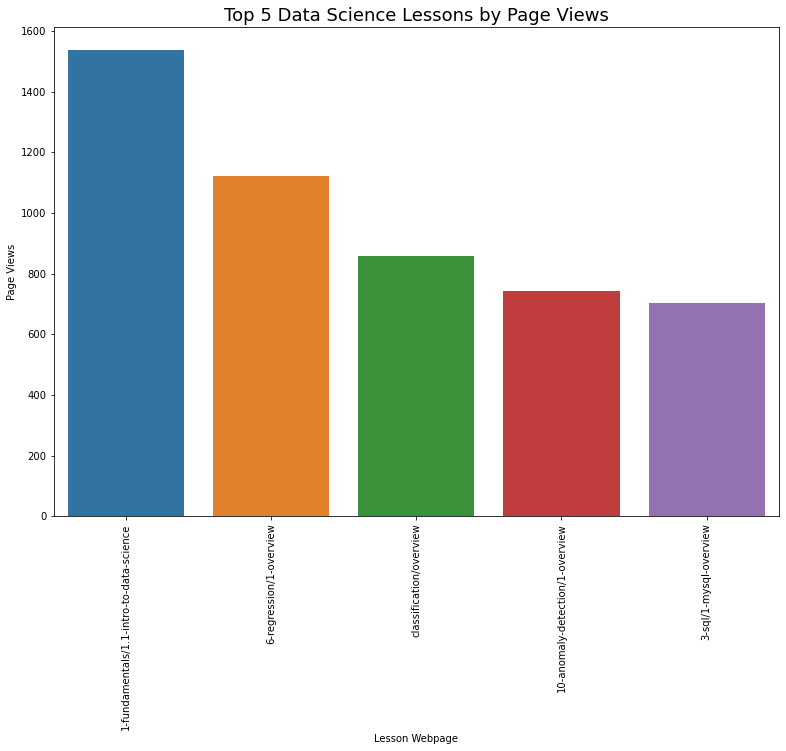

In [33]:
# Plotting the final graph to show top 5 most popular webpages in the webdev program

plt.figure(figsize = (13, 9))
sns.barplot(x = 'webpage', y = 'pageviews', data = dsdf_top_5)
plt.title("Top 5 Data Science Lessons by Page Views", fontsize = 18)
plt.ylabel("Page Views")
plt.xlabel("Lesson Webpage")
plt.xticks(rotation = 90)
plt.show()

#### Takeaways:

- For Webdev, 3 of the top 5 pages are related to Javascrip lessons
- For DS, into to DS, Regresson over, classification overview, anomaly detection over and SQL overview are the top 5 most viewed pages.

In [34]:
# Check out the rank function within .groupby().
# Run a 1 sample t-test on the pages seen by cohort type.
# eg, what is the average hits on pandas pages from the Curie cohort, vs the overall datascience average?
# Can I then turn that into a function for the high level pages, instead of the individual pages within each lesson?
# ie, group pages by module instead of by individual page...

### 2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 

In [73]:
ds_max_row_test = ds_page_counts.groupby(['cohort_id', 'webpage'])[['pageviews_by_cohort']].sum()

In [74]:
ds_max_row_test

pageviews_by_cohort
cohort_id webpage                                                                
34.0      1-fundamentals/1.1-intro-to-data-science                            615
          1-fundamentals/1.2-data-science-pipeline                            221
          1-fundamentals/1.3-pipeline-demo                                    130
          1-fundamentals/2.1-excel-overview                                    86
          1-fundamentals/2.1-spreadsheets-overview                              4
...                                                                           ...
59.0      timeseries/sarimax                                                    4
          timeseries/svr                                                        6
          timeseries/working-with-time-series-data                             83
          timeseries/working-with-time-series-data-with-p...                    4
          working-with-time-series-data                                        14

[1194 rows x 1 columns]

In [ ]:
# Using the unstack method to get one of the indexes into subcolumns:

ds_max_row_test.unstack(level = 0)

In [ ]:
ds_max_row[[ds_max_row.pageviews_by_cohort == ds_max_row.pageviews_by_cohort.max()]]

In [ ]:

ds_max_row.idxmax()

In [ ]:
ds_max_row.pageviews_by_cohort.rank()

I've almost gotten this, but I can't seem to figure out how to return just the first row of each cohort...

Maybe try .idxmax() after doing a boolean by cohort? something like that...

In [ ]:
ds_max_row.groupby(level = 0).apply(max)

# Need to somehow keep the webpage index in here.

In [ ]:
# [# Looks for a list to return [# regular python list here]]

In [ ]:
ds_max_row.sort_values(by = 'pageviews_by_cohort', ascending = False)

In [ ]:
ds_max_row.rank(axis = 0, ascending = False, method = 'max')

In [ ]:
ds_max_row[ds_max_row.index.get_level_values(0) == 34.0]

In [ ]:
ds_max_row_2 = ds_page_counts.groupby(['cohort_id', 'webpage'])[['pageviews_by_cohort']].sum()

In [91]:
ds_max_row = ds_df.copy()
ds_max_row

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
...,...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,2,15,Monday,True


In [92]:
ds_max_row = ds_max_row.groupby(['cohort_id', 'webpage'])['user_id'].count()
ds_max_row = ds_max_row.reset_index()
ds_max_row.rename(columns = {'user_id': 'pageviews'}, inplace = True)
ds_max_row

,cohort_id,webpage,pageviews
0,34.0,1-fundamentals/1.1-intro-to-data-science,615
1,34.0,1-fundamentals/1.2-data-science-pipeline,221
2,34.0,1-fundamentals/1.3-pipeline-demo,130
3,34.0,1-fundamentals/2.1-excel-overview,86
4,34.0,1-fundamentals/2.1-spreadsheets-overview,4
...,...,...,...
1086,59.0,timeseries/sarimax,4
1087,59.0,timeseries/svr,6
1088,59.0,timeseries/working-with-time-series-data,83
1089,59.0,timeseries/working-with-time-series-data-with-...,4


In [93]:
ds_max_row.sort_values(by = 'pageviews', ascending = False)

,cohort_id,webpage,pageviews
942,59.0,classification/overview,759
0,34.0,1-fundamentals/1.1-intro-to-data-science,615
531,55.0,6-regression/1-overview,595
158,34.0,6-regression/1-overview,521
1046,59.0,sql/mysql-overview,513
...,...,...,...
356,34.0,python/matplotlib-styles,1
354,34.0,python/intro-to-sklearn,1
716,55.0,regression/ridge-regression,1
640,55.0,clustering/about,1


In [88]:
ds_max_row = ds_max_row.groupby(['cohort_id', 'webpage'])[['pageviews']].sum()

In [89]:
ds_max_row

pageviews
cohort_id webpage                                                      
34.0      1-fundamentals/1.1-intro-to-data-science                  615
          1-fundamentals/1.2-data-science-pipeline                  221
          1-fundamentals/1.3-pipeline-demo                          130
          1-fundamentals/2.1-excel-overview                          86
          1-fundamentals/2.1-spreadsheets-overview                    4
...                                                                 ...
59.0      timeseries/sarimax                                          4
          timeseries/svr                                              6
          timeseries/working-with-time-series-data                   83
          timeseries/working-with-time-series-data-with-p...          4
          working-with-time-series-data                              14

[1091 rows x 1 columns]

In [94]:
cohort_list = ds_max_row.cohort_id.unique()
cohort_list

array([34., 55., 59.])

In [96]:
ds_max_row[ds_max_row.cohort_id == 59].sort_values(by = 'pageviews', ascending = False).head()

,cohort_id,webpage,pageviews
942,59.0,classification/overview,759
1046,59.0,sql/mysql-overview,513
772,59.0,1-fundamentals/1.1-intro-to-data-science,460
1054,59.0,stats/compare-means,338
941,59.0,classification/logistic-regression,334


In [98]:
# Doing a for loop to find the top 5 page views by cohort. I should be able to separate them and create bar charts or another kind of chart.

top_5 = []

for c in cohort_list:
    top_5.append(ds_max_row[ds_max_row.cohort_id == c].sort_values(by = 'pageviews', ascending = False).head(5))

# create a list of dfs
cohort_34_5 = top_5[0]
cohort_55_5 = top_5[1]
cohort_59_5 = top_5[2]

In [99]:
top_5

[     cohort_id                                   webpage  pageviews
 0         34.0  1-fundamentals/1.1-intro-to-data-science        615
 158       34.0                   6-regression/1-overview        521
 14        34.0           10-anomaly-detection/1-overview        383
 173       34.0                 6-regression/5.0-evaluate        333
 145       34.0       5-stats/3-probability-distributions        320,
      cohort_id                                   webpage  pageviews
 531       55.0                   6-regression/1-overview        595
 411       55.0  1-fundamentals/1.1-intro-to-data-science        461
 470       55.0                    3-sql/1-mysql-overview        441
 423       55.0           10-anomaly-detection/1-overview        345
 506       55.0                 4-python/8.4.3-dataframes        260,
       cohort_id                                   webpage  pageviews
 942        59.0                   classification/overview        759
 1046       59.0              

In [100]:
cohort_34_5

,cohort_id,webpage,pageviews
0,34.0,1-fundamentals/1.1-intro-to-data-science,615
158,34.0,6-regression/1-overview,521
14,34.0,10-anomaly-detection/1-overview,383
173,34.0,6-regression/5.0-evaluate,333
145,34.0,5-stats/3-probability-distributions,320


In [101]:
cohort_59_5

,cohort_id,webpage,pageviews
942,59.0,classification/overview,759
1046,59.0,sql/mysql-overview,513
772,59.0,1-fundamentals/1.1-intro-to-data-science,460
1054,59.0,stats/compare-means,338
941,59.0,classification/logistic-regression,334


In [102]:
cohort_59_5

,cohort_id,webpage,pageviews
942,59.0,classification/overview,759
1046,59.0,sql/mysql-overview,513
772,59.0,1-fundamentals/1.1-intro-to-data-science,460
1054,59.0,stats/compare-means,338
941,59.0,classification/logistic-regression,334


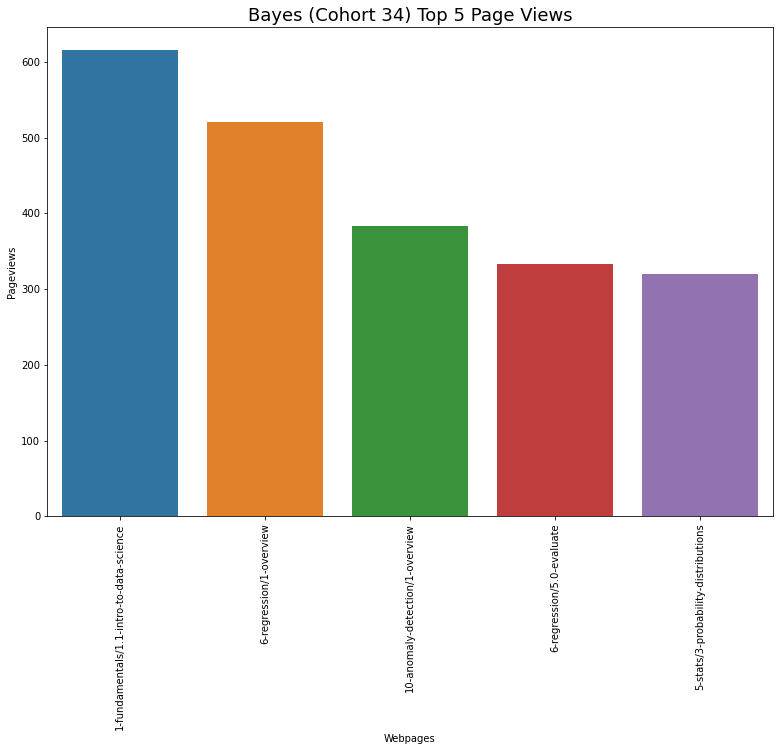

In [106]:
# Charting the data science

plt.figure(figsize = (13, 9))
sns.barplot(x = 'webpage', y = 'pageviews', data = cohort_34_5)
plt.xticks(rotation = 90)
plt.title("Bayes (Cohort 34) Top 5 Page Views", fontsize = 18)
plt.ylabel("Pageviews")
plt.xlabel("Webpages")
plt.show()

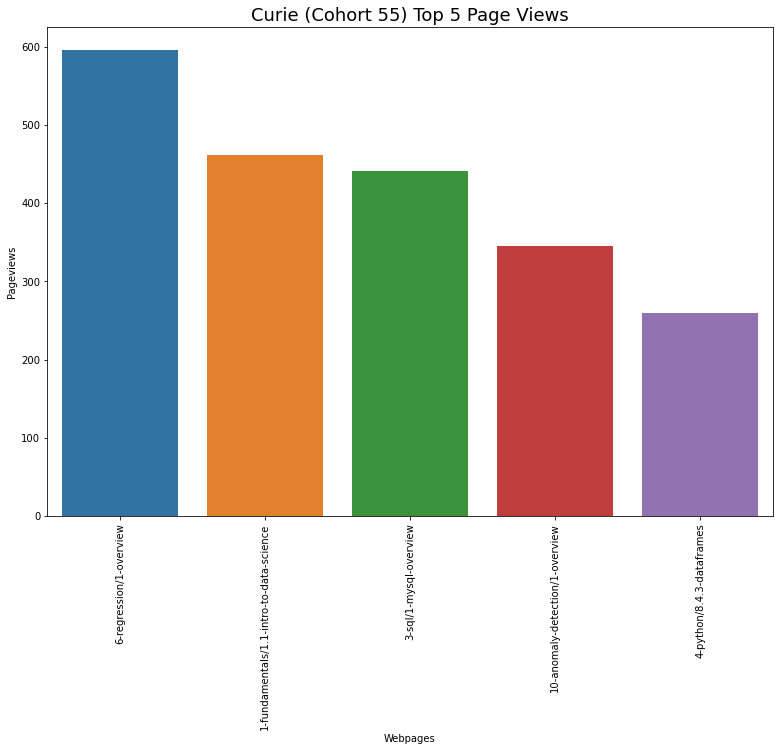

In [107]:
# Charting the data science

plt.figure(figsize = (13, 9))
sns.barplot(x = 'webpage', y = 'pageviews', data = cohort_55_5)
plt.xticks(rotation = 90)
plt.title("Curie (Cohort 55) Top 5 Page Views", fontsize = 18)
plt.ylabel("Pageviews")
plt.xlabel("Webpages")
plt.show()

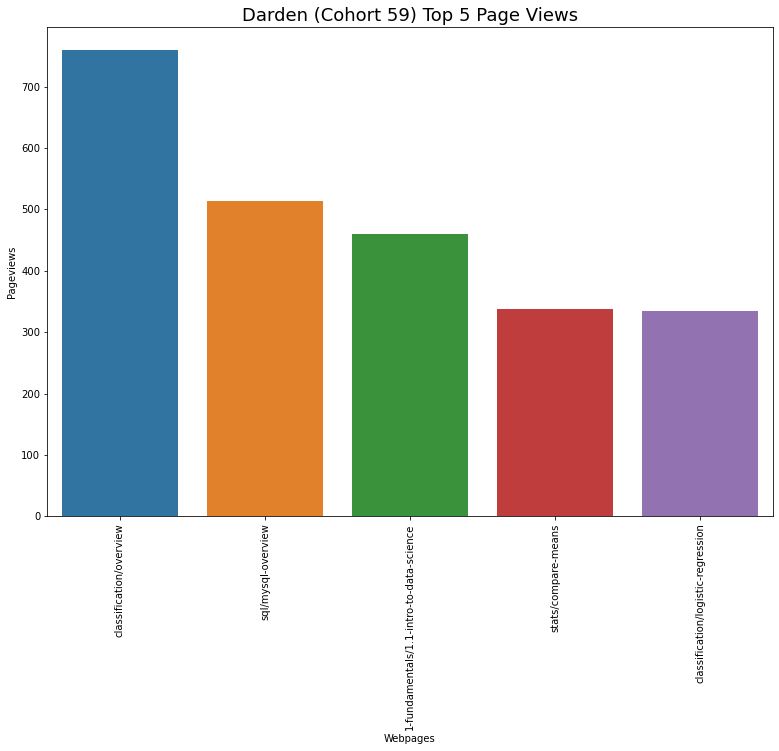

In [108]:
# Charting the data science

plt.figure(figsize = (13, 9))
sns.barplot(x = 'webpage', y = 'pageviews', data = cohort_59_5)
plt.xticks(rotation = 90)
plt.title("Darden (Cohort 59) Top 5 Page Views", fontsize = 18)
plt.ylabel("Pageviews")
plt.xlabel("Webpages")
plt.show()

In [109]:
pd.DataFrame(ds_df.user_id.value_counts().head(5)).index

Int64Index([581, 685, 475, 479, 485], dtype='int64')

In [ ]:
# Ideas from Maggie:
# df[df.cohort_id == c]
# df[df.cohort_id==c].head()
# Top_5 = []

### Webdev Cohorts

In [110]:
wd_df = df[(~df.cohort_id.isin([30, 34, 55, 59]))]
wd_df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False


In [111]:
wd_df = wd_df.groupby(['webpage', 'cohort_id'])['user_id'].count()
wd_df = wd_df.reset_index()
wd_df

,webpage,cohort_id,user_id
0,.git,24.0,1
1,.gitignore,24.0,1
2,.well-known/assetlinks.json,58.0,2
3,/,1.0,622
4,/,2.0,17
...,...,...,...
10576,web-design/ux/purpose,62.0,1
10577,web-dev-day-two,61.0,2
10578,working-with-time-series-data,28.0,1
10579,wp-admin,22.0,1


In [112]:
# Can I turn this into a for loop? (Yes, once MVP is done)
wd_df = wd_df[wd_df.webpage != "/"]
wd_df = wd_df[~wd_df.webpage.str.contains("github.com")]
wd_df = wd_df[~wd_df.webpage.str.contains("jpeg")]
wd_df = wd_df[~wd_df.webpage.str.contains("toc")]
wd_df = wd_df[~wd_df.webpage.str.contains(".gitignore")]
wd_df = wd_df[~wd_df.webpage.str.contains(".git")]
wd_df = wd_df[~wd_df.webpage.str.contains("json")]
wd_df = wd_df[~wd_df.webpage.str.contains("wp-login")]
wd_df.sort_values(by = 'user_id', ascending = False)

,webpage,cohort_id,user_id
6999,javascript-i,28.0,1263
1192,appendix,28.0,989
5587,html-css,28.0,977
7003,javascript-i,33.0,977
9827,spring,28.0,914
...,...,...,...
4438,content/php_ii/control-structures-i/do-while.html,23.0,1
4443,content/php_ii/control-structures-i/else-elsei...,18.0,1
4462,content/php_ii/control-structures-i/if-continu...,21.0,1
4463,content/php_ii/control-structures-i/if-continu...,22.0,1


In [113]:
wd_df.rename(columns = {'user_id': 'pageviews'}, inplace = True)

In [114]:
wd_cohort_list = wd_df.cohort_id.unique()
wd_cohort_list

array([28., 25.,  1.,  8., 22., 23., 24., 29.,  7., 14., 19., 21., 31.,
       32., 33., 52., 51., 27., 18., 26.,  6., 61., 57., 11., 13., 15.,
       16., 17., 53., 56., 58., 62., 12.,  2.,  9.,  4.])

In [115]:
wd_top_5 = []

for c in wd_cohort_list:
    wd_top_5.append(wd_df[wd_df.cohort_id == c].sort_values(by = 'pageviews', ascending = False).head(5))

# create a list of dfs
# cohort_34_5 = wd_top_5[0]
# cohort_55_5 = top_5[1]
# cohort_59_5 = top_5[2]

In [116]:
wd_top_5

[           webpage  cohort_id  pageviews
 6999  javascript-i       28.0       1263
 1192      appendix       28.0        989
 5587      html-css       28.0        977
 9827        spring       28.0        914
 6718      java-iii       28.0        908,
            webpage  cohort_id  pageviews
 6996  javascript-i       25.0        553
 5584      html-css       25.0        405
 6194        java-i       25.0        401
 7923        jquery       25.0        374
 6715      java-iii       25.0        335,
             webpage  cohort_id  pageviews
 6978   javascript-i        1.0        294
 5566       html-css        1.0        215
 7667  javascript-ii        1.0        204
 9808         spring        1.0        192
 6394        java-ii        1.0        167,
        webpage  cohort_id  pageviews
 6701  java-iii        8.0         57
 1176  appendix        8.0         55
 6396   java-ii        8.0         46
 6180    java-i        8.0         46
 9811    spring        8.0         43,
      

In [ ]:
# Nice to have: create individual dataframes for webdev just like I did for data science 

In [117]:
len(wd_cohort_list)

36

In [ ]:
# Attemping to create unique dataframes for each item in the above dataframe list... Was told that isn't possible.

# for r in range:
#     df[r] = wd_top_5[r]

#### Takeaways:

- For data science cohorts, each cohort seems to have spent more time on different lessons. Bayes' most viewed was into to data science, Curie was the My SQL overview, and Darden so far has spent the most time in the Classification overview page.

- In the Webdev cohorts, the javascript and spring lessons were consistently in the top 5, however cohorts 9 and 17 had dramatically different top 5 lesson pageviews, with html and laravel/php lessons taking the top spots.

## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 

In [277]:
df_merge.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,Hampton,2015-09-22,2016-02-06,1,False


In [278]:
df2 = df_merge2.copy()

In [279]:
df2['date'] = df2.index

In [209]:
df2_ds = df2[df2.cohort_id.isin([30, 34, 55, 59])]
df2_ds['date'] = df2.index[df2.cohort_id.isin([30, 34, 55, 59])]

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active,date
date,,,,,,,,,,,,,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:39:58
2019-08-20 09:39:59,/,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:39:59
2019-08-20 09:39:59,/,468,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:39:59
2019-08-20 09:40:02,/,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:40:02
2019-08-20 09:40:08,/,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:40:08


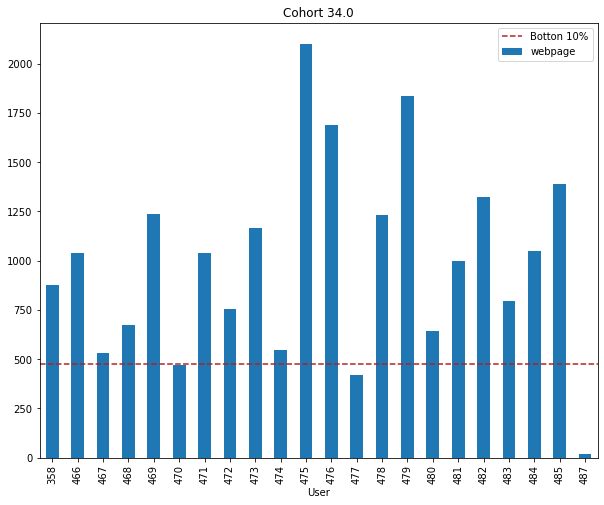

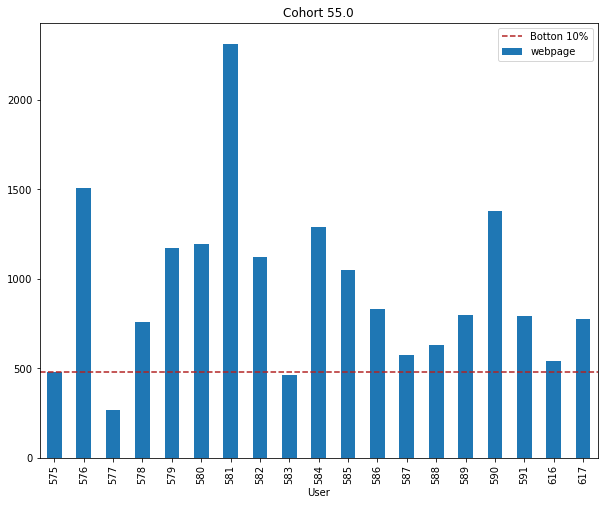

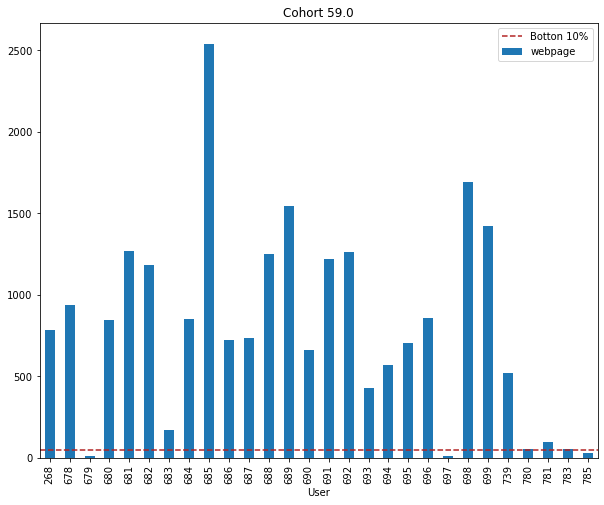

In [674]:
ds_list = [34.0, 55.0, 59.0]

for x in ds_list:
    df1 = df2_ds[df2_ds.cohort_id == x]
    plt.figure(figsize = (10, 8))
    cohort_page_views = df1[df1.date.between(df1.start_date, df1.end_date, inclusive = True)].groupby('user_id').webpage.count()
    cohort_page_views.plot(kind = 'bar')
    low_cut_ds = cohort_page_views.quantile(q = .1)
    plt.axhline(y = low_cut_ds, xmin = 0, xmax = 1, linestyle = '--', color = 'firebrick', label = "Botton 10%")
    plt.title(f"Cohort {x}")
    plt.xlabel("User")
    plt.legend()
    plt.show()
    
# I would like to add labels, and more importantly I'd want to add the horizontal like at the 10% percentile within each group. But that'll take too long at this point I think.

In [ ]:
# Isolating a student in 

### Webdev Cohorts

In [280]:
# Creating a list of webdev cohort ids to be used in the for loop:

webdev_list = df[~df.cohort_id.isin([30, 34, 55, 59])]
webdev_list = webdev_list.cohort_id.unique()
webdev_list = webdev_list[~np.isnan(webdev_list)]
webdev_list

array([ 8., 22., 21.,  1., 16., 18., 19., 13., 14., 15.,  7.,  4., 12.,
       17., 23.,  2.,  9., 11., 24., 25., 26.,  6., 27., 28., 29., 31.,
       32., 33., 51., 52., 53., 56., 57.,  5., 58., 61., 62.])

In [284]:
df2_wd = df2[~df2.cohort_id.isin([30, 34, 55, 59])]
df2_wd.is_ds.value_counts()

False    606602
Name: is_ds, dtype: int64

In [287]:
df2_wd.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active,date
date,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False,2018-01-26 09:56:06
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,Hampton,2015-09-22,2016-02-06,1,False,2018-01-26 10:40:15


In [304]:
webdev_list

array([ 8., 22., 21.,  1., 16., 18., 19., 13., 14., 15.,  7.,  4., 12.,
       17., 23.,  2.,  9., 11., 24., 25., 26.,  6., 27., 28., 29., 31.,
       32., 33., 51., 52., 53., 56., 57.,  5., 58., 61., 62.])

No data found for cohort 8.0.


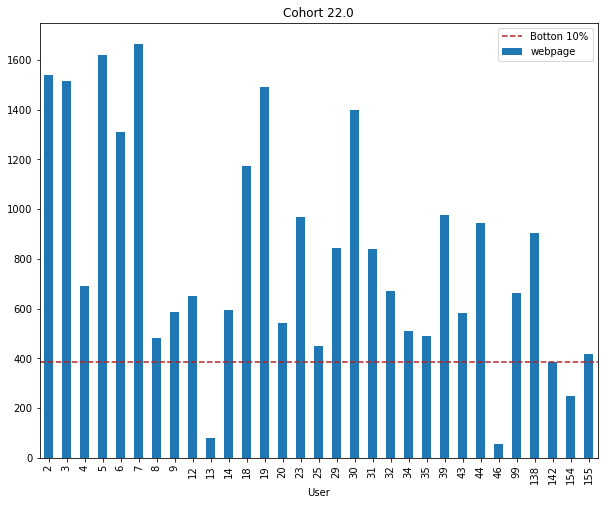

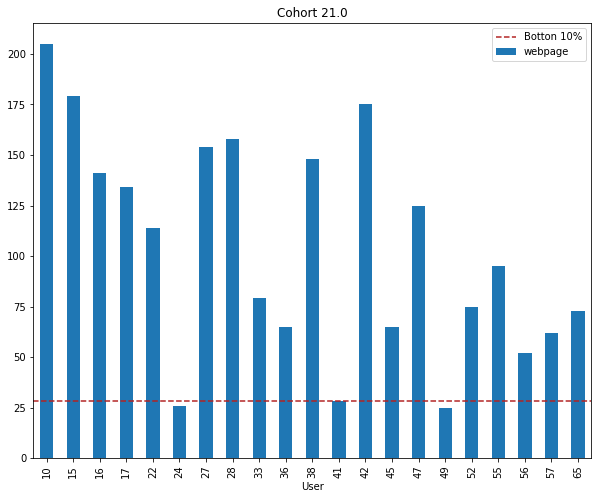

No data found for cohort 1.0.
No data found for cohort 16.0.
No data found for cohort 18.0.
No data found for cohort 19.0.
No data found for cohort 13.0.
No data found for cohort 14.0.
No data found for cohort 15.0.
No data found for cohort 7.0.
No data found for cohort 4.0.
No data found for cohort 12.0.
No data found for cohort 17.0.


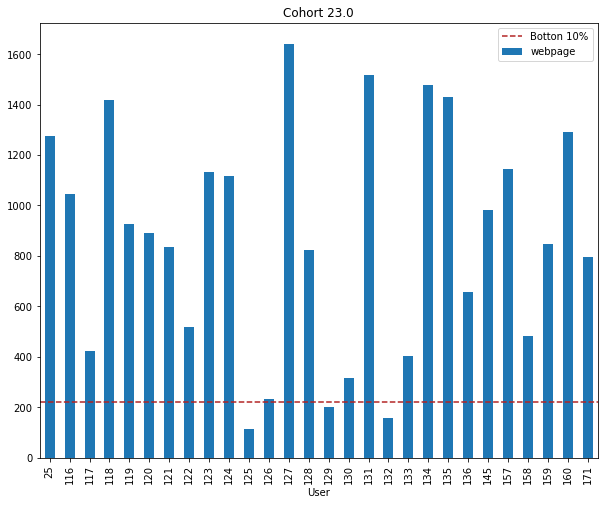

No data found for cohort 2.0.
No data found for cohort 9.0.
No data found for cohort 11.0.


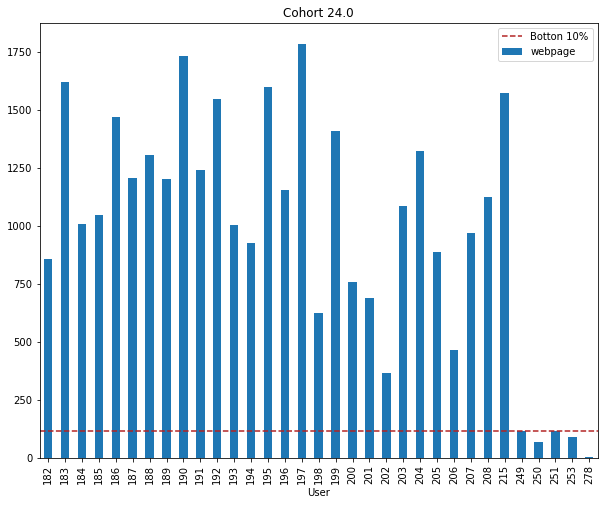

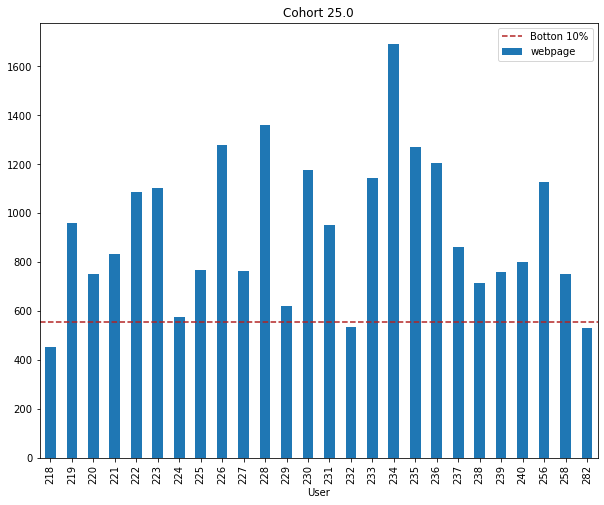

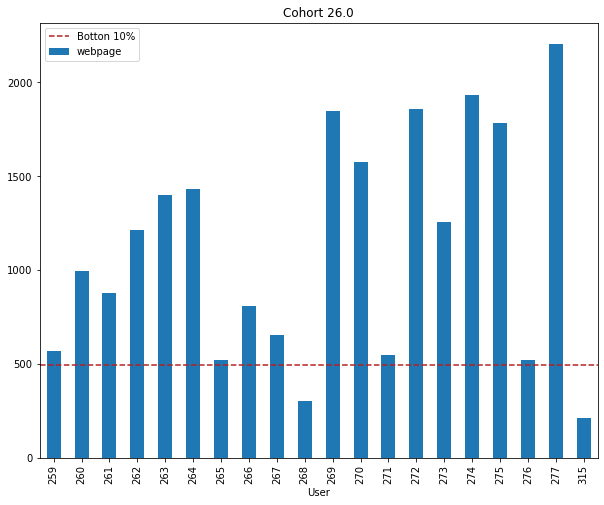

No data found for cohort 6.0.


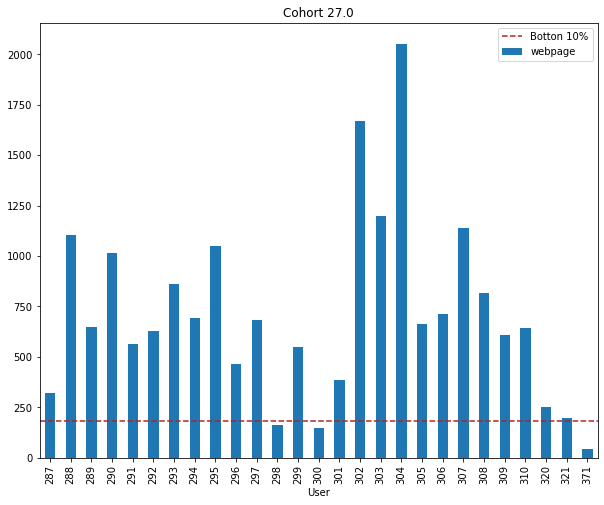

No data found for cohort 28.0.


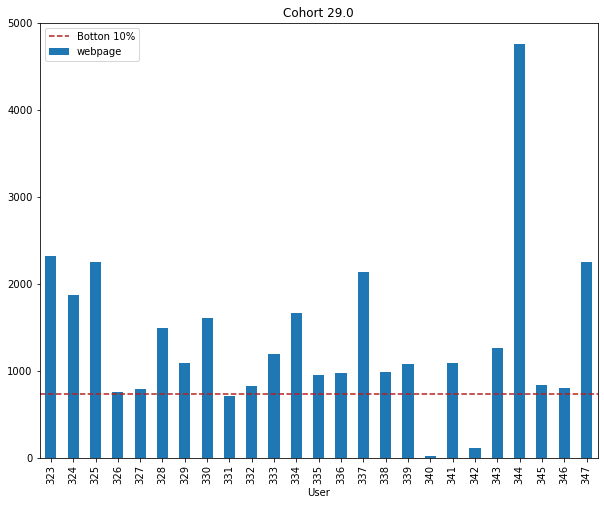

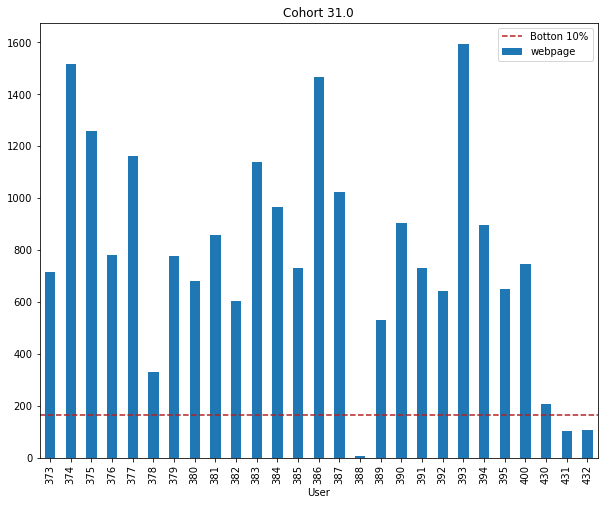

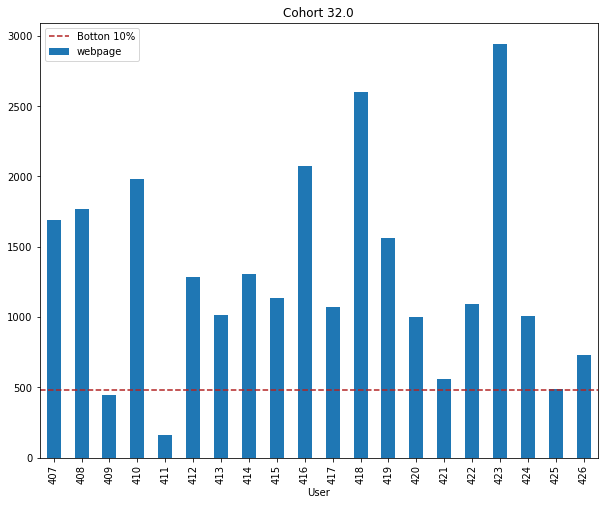

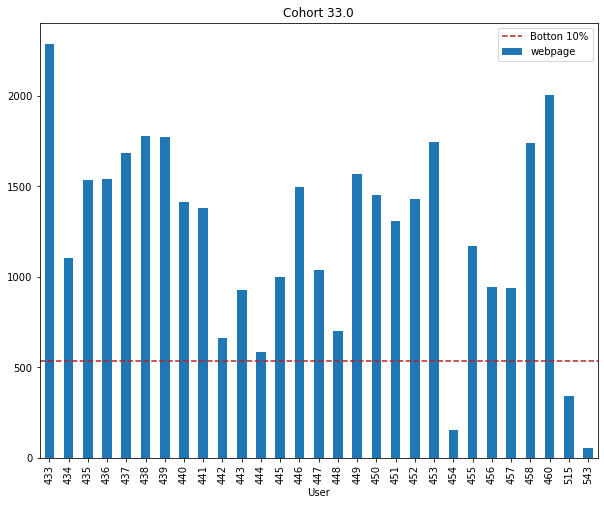

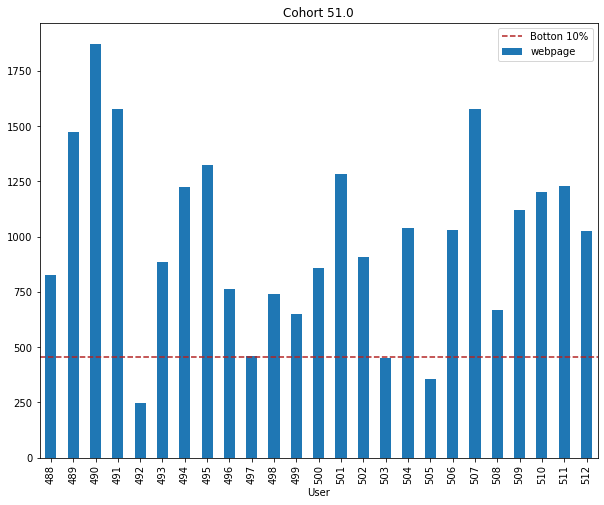

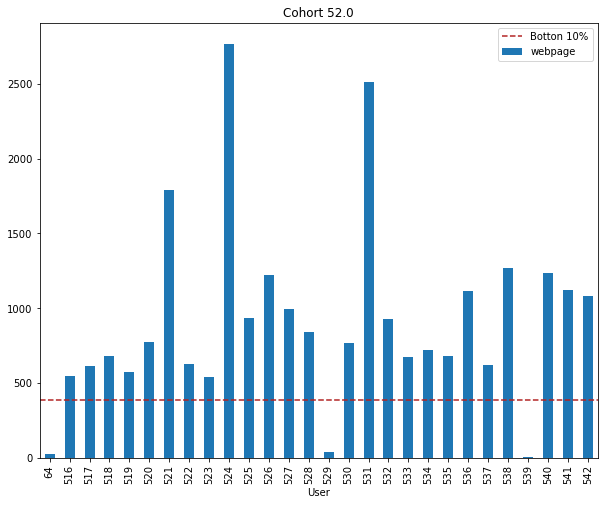

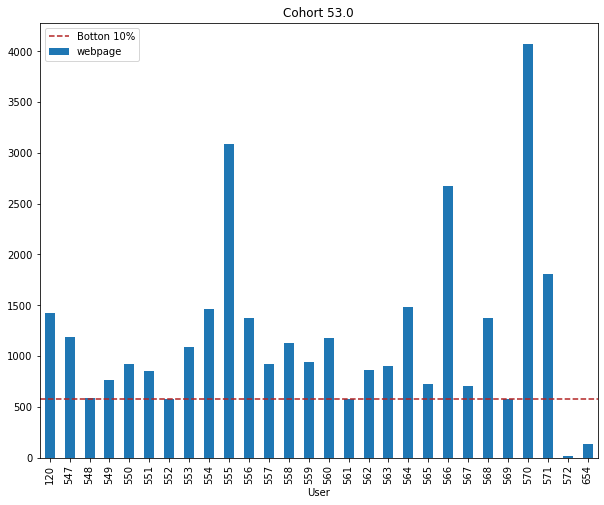

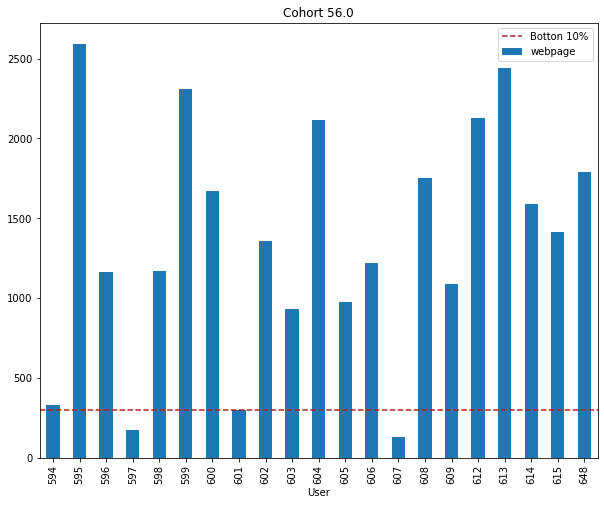

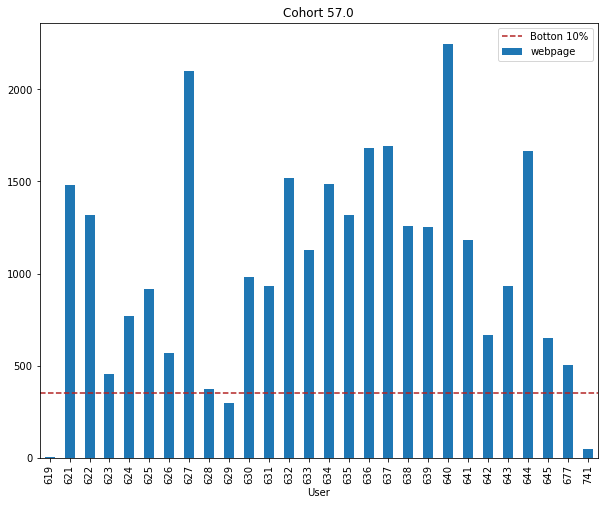

No data found for cohort 5.0.


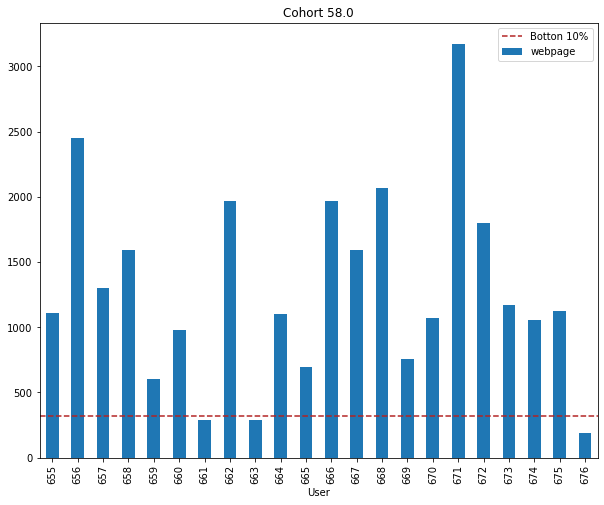

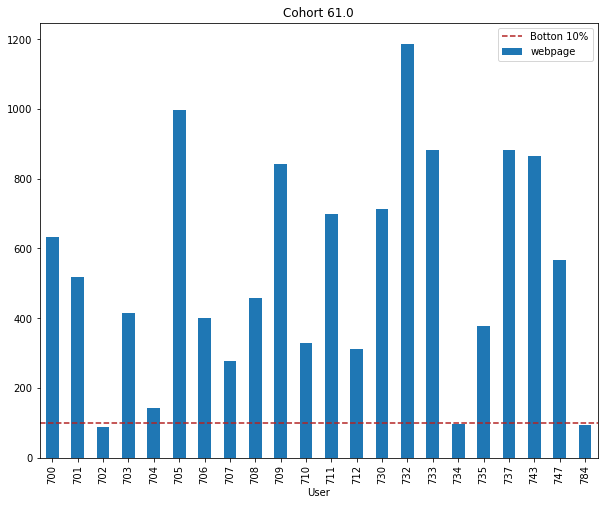

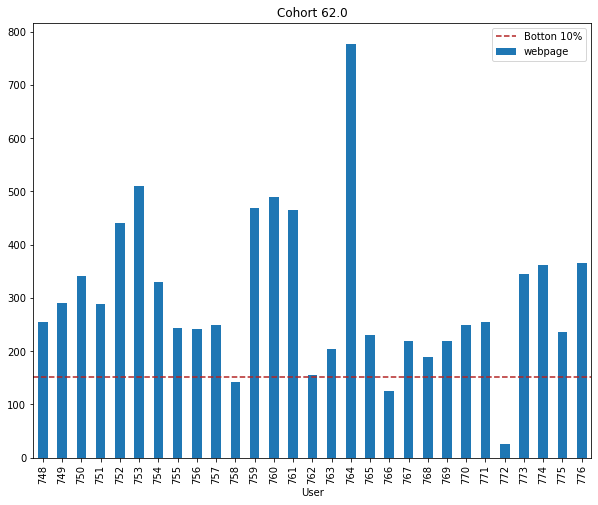

In [500]:
for x in webdev_list:
    df1 = df2_wd[df2_wd.cohort_id == x]
    if df1.date.between(df1.start_date, df1.end_date, inclusive = True).any():
        plt.figure(figsize = (10, 8))
        cohort_page_views = df1[df1.date.between(df1.start_date, df1.end_date, inclusive = True)].groupby('user_id').webpage.count()
        cohort_page_views.plot(kind = 'bar')
        low_cut = cohort_page_views.quantile(q = .1)
        plt.axhline(y = low_cut, xmin = 0, xmax = 1, linestyle = '--', label = "Botton 10%", color = "firebrick")
        plt.title(f"Cohort {x}")
        plt.xlabel("User")
        plt.legend()
        plt.show()
    else:
        print(f"No data found for cohort {x}.")
        
# If there is more time I'd like to search for the cohort name and return it by the cohort id column.

#### Takeaways:

- For each of the webdev cohorts that we have data on, there are on average 3-4 user ids that fall below the cohort's 10th percentile of page views.
    - This could be due to user ids being changed in the middle of class, or it could be the result of a student dropping out from a class.
- **End result; on average, 3-4 students (based on `user_id`) are below the 10th percentile of pages viewed per cohort.**

#### Is this a CodeUp employee?
- This was the only ip address to access a webpage called "wp-admin". Maybe a wordpress admin webpage?

In [ ]:
explore = df.copy()
explore[explore.webpage == 'wp-admin']

In [ ]:
explore[explore.ip == '70.121.163.5']

## 4. Finding Suspicious Activity

- Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 

## IP Location Mapper:

- Using geoip python library

In [326]:
ds_df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True


In [327]:
df_sus = ds_df.copy()
df_sus

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
...,...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,2,15,Monday,True
2020-11-02 15:48:14,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,2,15,Monday,True


In [333]:
ips = df_sus.ip.unique()

In [355]:
ips_count = df_sus.ip.nunique()
ips_count

547

### Looking for suspicious IP addresses

In [344]:
ds_ips = pd.DataFrame(ips)
ds_ips.rename(columns = {0: 'ip'}, inplace = True)
ds_ips.head()

,ip
0,97.105.19.58
1,67.11.115.125
2,172.8.173.224
3,173.175.104.33
4,12.197.196.242


In [347]:
ips_locate = []
n = 0
ips_ds_count = df_sus.ip.nunique()

for index, row in ds_ips.iterrows():
    location = row['ip']
    url = "https://freegeoip.app/json/" + location
    headers = {
    'accept': "application/json",
    'content-type': "application/json"
    }

    response = requests.request("GET", url, headers=headers)
    data = response.json()
    ips_locate.append(data)
    
    n = n + 1
    print(f"Loop number {n} of {ips_ds_count}")

Loop number 1
Loop number 2
Loop number 3
Loop number 4
Loop number 5
Loop number 6
Loop number 7
Loop number 8
Loop number 9
Loop number 10
Loop number 11
Loop number 12
Loop number 13
Loop number 14
Loop number 15
Loop number 16
Loop number 17
Loop number 18
Loop number 19
Loop number 20
Loop number 21
Loop number 22
Loop number 23
Loop number 24
Loop number 25
Loop number 26
Loop number 27
Loop number 28
Loop number 29
Loop number 30
Loop number 31
Loop number 32
Loop number 33
Loop number 34
Loop number 35
Loop number 36
Loop number 37
Loop number 38
Loop number 39
Loop number 40
Loop number 41
Loop number 42
Loop number 43
Loop number 44
Loop number 45
Loop number 46
Loop number 47
Loop number 48
Loop number 49
Loop number 50
Loop number 51
Loop number 52
Loop number 53
Loop number 54
Loop number 55
Loop number 56
Loop number 57
Loop number 58
Loop number 59
Loop number 60
Loop number 61
Loop number 62
Loop number 63
Loop number 64
Loop number 65
Loop number 66
Loop number 67
Loop

Loop number 520
Loop number 521
Loop number 522
Loop number 523
Loop number 524
Loop number 525
Loop number 526
Loop number 527
Loop number 528
Loop number 529
Loop number 530
Loop number 531
Loop number 532
Loop number 533
Loop number 534
Loop number 535
Loop number 536
Loop number 537
Loop number 538
Loop number 539
Loop number 540
Loop number 541
Loop number 542
Loop number 543
Loop number 544
Loop number 545
Loop number 546
Loop number 547


In [351]:
ip_data = pd.DataFrame(ips_locate)

In [353]:
df_sus = df_sus.merge(ip_data, how= 'left', on = 'ip')
df_sus

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
1,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
2,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
3,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
4,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52912,appendix/useful_libraries,698,59.0,24.28.150.196,2020,11,2,15,Monday,True,US,United States,TX,Texas,San Antonio,78251,America/Chicago,29.4551,-98.6498,641
52913,appendix/ds-environment-setup,698,59.0,24.28.150.196,2020,11,2,15,Monday,True,US,United States,TX,Texas,San Antonio,78251,America/Chicago,29.4551,-98.6498,641
52914,appendix/interview_questions_students,698,59.0,24.28.150.196,2020,11,2,15,Monday,True,US,United States,TX,Texas,San Antonio,78251,America/Chicago,29.4551,-98.6498,641
52915,appendix/open_data,698,59.0,24.28.150.196,2020,11,2,15,Monday,True,US,United States,TX,Texas,San Antonio,78251,America/Chicago,29.4551,-98.6498,641


In [356]:
# Doing some cleanup work
# df_sus.drop(columns = ['year', 'month', ])

In [365]:
df_sus.groupby('country_name')[['webpage']].count().sort_values(by = 'webpage', ascending = False)

,webpage
country_name,
United States,52669
Canada,157
Mexico,32
Germany,30
Ireland,15
Australia,11
China,2


Looks like there are several foreign locations pinging the server. I'm going to look at China first.

In [368]:
df_sus[df_sus.country_name == 'China']

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
27966,7-classification/2-acquire,590,55.0,221.229.204.176,2020,4,21,22,Tuesday,True,CN,China,BJ,Beijing,Beijing,,Asia/Shanghai,39.9288,116.3889,0
27967,7-classification/3-prep,590,55.0,221.229.204.176,2020,4,21,22,Tuesday,True,CN,China,BJ,Beijing,Beijing,,Asia/Shanghai,39.9288,116.3889,0


In [370]:
# Now looking thru all foreign locations:
ds_foreign_ip = df_sus[df_sus.country_name != 'United States']

In [380]:
ds_foreign_ip.groupby(['country_name', 'user_id'])[['ip']].count().sort_values(by = 'ip', ascending = False)

,,ip
country_name,user_id,
Canada,469,157
Mexico,476,32
Germany,469,30
Ireland,469,15
Australia,469,11
China,590,2


In [682]:
# This code will return the % of page views for user 469 that occured from an ip address outside the US:

round(df_sus[(df_sus.user_id == 469) & (df_sus.country_name != 'United States')].shape[0] / df_sus[(df_sus.user_id == 469)].shape[0], 3)

0.203

In [478]:
ds_foreign_chart = ds_foreign_ip.country_name.value_counts()

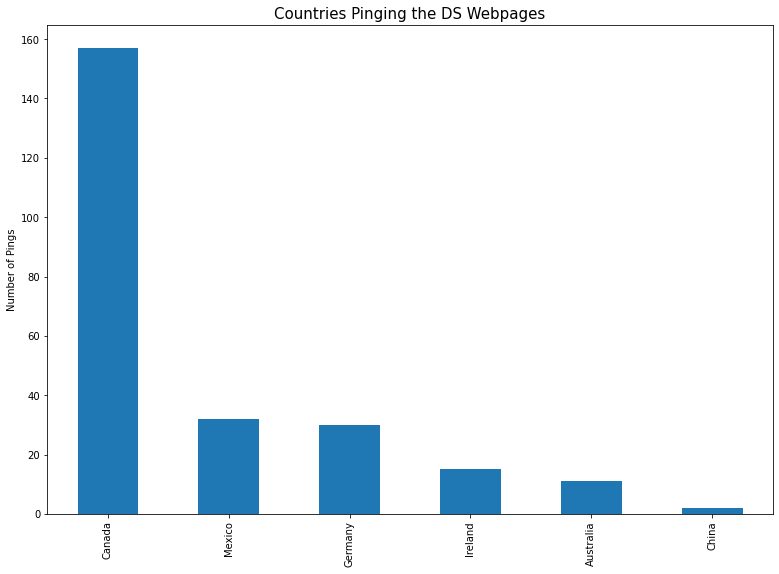

In [659]:
ds_foreign_chart.plot(kind = "bar", figsize = (13, 9))
plt.title("Countries Pinging the DS Webpages", fontsize = 15)
plt.ylabel("Number of Pings")
plt.show()

#### Takeaway:
- It appears there are 3 users accessing the data science webpages from non-US locations. More research into users 469, 476, 590 would be appropriate, to see if those users are students using a VPN, or if they are bad actors.

### Webdev Suspicious IPs

In [632]:
wd_df = df[(~df.cohort_id.isin([30, 34, 55, 59]))]
wd_df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,date
date_time,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:55:03
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:02
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:05
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:06
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,2018-01-26 09:56:24


In [633]:
wd_df = wd_df[wd_df.webpage != "/"]
wd_df = wd_df[~wd_df.webpage.str.contains("github.com|jpeg|jpg|svg|toc|.gitignore|.git|json")]

In [636]:
# Creating a list of unquie IP addresses
wd_ips = wd_df.ip.unique()
#Find the count of the unique IPs
wd_ips_count = wd_df.ip.nunique()
wd_ips_count

3541

In [638]:
wd_ips = pd.DataFrame(wd_ips)
wd_ips.rename(columns = {0: 'ip'}, inplace = True)
wd_ips.shape

(3541, 1)

In [639]:
# This loop will append the location data by using the IP address API.

wd_ips_locate = []
n = 0
ips_wd_count = wd_df.ip.nunique()

for index, row in wd_ips.iterrows():
    location = row['ip']
    url = "https://freegeoip.app/json/" + location
    headers = {
    'accept': "application/json",
    'content-type': "application/json"
    }

    response = requests.request("GET", url, headers=headers)
    data = response.json()
    wd_ips_locate.append(data)
    
    n = n + 1
    print(f"Loop number {n} of {ips_wd_count}")

Loop number 1 of 3541
Loop number 2 of 3541
Loop number 3 of 3541
Loop number 4 of 3541
Loop number 5 of 3541
Loop number 6 of 3541
Loop number 7 of 3541
Loop number 8 of 3541
Loop number 9 of 3541
Loop number 10 of 3541
Loop number 11 of 3541
Loop number 12 of 3541
Loop number 13 of 3541
Loop number 14 of 3541
Loop number 15 of 3541
Loop number 16 of 3541
Loop number 17 of 3541
Loop number 18 of 3541
Loop number 19 of 3541
Loop number 20 of 3541
Loop number 21 of 3541
Loop number 22 of 3541
Loop number 23 of 3541
Loop number 24 of 3541
Loop number 25 of 3541
Loop number 26 of 3541
Loop number 27 of 3541
Loop number 28 of 3541
Loop number 29 of 3541
Loop number 30 of 3541
Loop number 31 of 3541
Loop number 32 of 3541
Loop number 33 of 3541
Loop number 34 of 3541
Loop number 35 of 3541
Loop number 36 of 3541
Loop number 37 of 3541
Loop number 38 of 3541
Loop number 39 of 3541
Loop number 40 of 3541
Loop number 41 of 3541
Loop number 42 of 3541
Loop number 43 of 3541
Loop number 44 of 35

Loop number 347 of 3541
Loop number 348 of 3541
Loop number 349 of 3541
Loop number 350 of 3541
Loop number 351 of 3541
Loop number 352 of 3541
Loop number 353 of 3541
Loop number 354 of 3541
Loop number 355 of 3541
Loop number 356 of 3541
Loop number 357 of 3541
Loop number 358 of 3541
Loop number 359 of 3541
Loop number 360 of 3541
Loop number 361 of 3541
Loop number 362 of 3541
Loop number 363 of 3541
Loop number 364 of 3541
Loop number 365 of 3541
Loop number 366 of 3541
Loop number 367 of 3541
Loop number 368 of 3541
Loop number 369 of 3541
Loop number 370 of 3541
Loop number 371 of 3541
Loop number 372 of 3541
Loop number 373 of 3541
Loop number 374 of 3541
Loop number 375 of 3541
Loop number 376 of 3541
Loop number 377 of 3541
Loop number 378 of 3541
Loop number 379 of 3541
Loop number 380 of 3541
Loop number 381 of 3541
Loop number 382 of 3541
Loop number 383 of 3541
Loop number 384 of 3541
Loop number 385 of 3541
Loop number 386 of 3541
Loop number 387 of 3541
Loop number 388 

Loop number 689 of 3541
Loop number 690 of 3541
Loop number 691 of 3541
Loop number 692 of 3541
Loop number 693 of 3541
Loop number 694 of 3541
Loop number 695 of 3541
Loop number 696 of 3541
Loop number 697 of 3541
Loop number 698 of 3541
Loop number 699 of 3541
Loop number 700 of 3541
Loop number 701 of 3541
Loop number 702 of 3541
Loop number 703 of 3541
Loop number 704 of 3541
Loop number 705 of 3541
Loop number 706 of 3541
Loop number 707 of 3541
Loop number 708 of 3541
Loop number 709 of 3541
Loop number 710 of 3541
Loop number 711 of 3541
Loop number 712 of 3541
Loop number 713 of 3541
Loop number 714 of 3541
Loop number 715 of 3541
Loop number 716 of 3541
Loop number 717 of 3541
Loop number 718 of 3541
Loop number 719 of 3541
Loop number 720 of 3541
Loop number 721 of 3541
Loop number 722 of 3541
Loop number 723 of 3541
Loop number 724 of 3541
Loop number 725 of 3541
Loop number 726 of 3541
Loop number 727 of 3541
Loop number 728 of 3541
Loop number 729 of 3541
Loop number 730 

Loop number 1030 of 3541
Loop number 1031 of 3541
Loop number 1032 of 3541
Loop number 1033 of 3541
Loop number 1034 of 3541
Loop number 1035 of 3541
Loop number 1036 of 3541
Loop number 1037 of 3541
Loop number 1038 of 3541
Loop number 1039 of 3541
Loop number 1040 of 3541
Loop number 1041 of 3541
Loop number 1042 of 3541
Loop number 1043 of 3541
Loop number 1044 of 3541
Loop number 1045 of 3541
Loop number 1046 of 3541
Loop number 1047 of 3541
Loop number 1048 of 3541
Loop number 1049 of 3541
Loop number 1050 of 3541
Loop number 1051 of 3541
Loop number 1052 of 3541
Loop number 1053 of 3541
Loop number 1054 of 3541
Loop number 1055 of 3541
Loop number 1056 of 3541
Loop number 1057 of 3541
Loop number 1058 of 3541
Loop number 1059 of 3541
Loop number 1060 of 3541
Loop number 1061 of 3541
Loop number 1062 of 3541
Loop number 1063 of 3541
Loop number 1064 of 3541
Loop number 1065 of 3541
Loop number 1066 of 3541
Loop number 1067 of 3541
Loop number 1068 of 3541
Loop number 1069 of 3541


Loop number 1359 of 3541
Loop number 1360 of 3541
Loop number 1361 of 3541
Loop number 1362 of 3541
Loop number 1363 of 3541
Loop number 1364 of 3541
Loop number 1365 of 3541
Loop number 1366 of 3541
Loop number 1367 of 3541
Loop number 1368 of 3541
Loop number 1369 of 3541
Loop number 1370 of 3541
Loop number 1371 of 3541
Loop number 1372 of 3541
Loop number 1373 of 3541
Loop number 1374 of 3541
Loop number 1375 of 3541
Loop number 1376 of 3541
Loop number 1377 of 3541
Loop number 1378 of 3541
Loop number 1379 of 3541
Loop number 1380 of 3541
Loop number 1381 of 3541
Loop number 1382 of 3541
Loop number 1383 of 3541
Loop number 1384 of 3541
Loop number 1385 of 3541
Loop number 1386 of 3541
Loop number 1387 of 3541
Loop number 1388 of 3541
Loop number 1389 of 3541
Loop number 1390 of 3541
Loop number 1391 of 3541
Loop number 1392 of 3541
Loop number 1393 of 3541
Loop number 1394 of 3541
Loop number 1395 of 3541
Loop number 1396 of 3541
Loop number 1397 of 3541
Loop number 1398 of 3541


Loop number 1687 of 3541
Loop number 1688 of 3541
Loop number 1689 of 3541
Loop number 1690 of 3541
Loop number 1691 of 3541
Loop number 1692 of 3541
Loop number 1693 of 3541
Loop number 1694 of 3541
Loop number 1695 of 3541
Loop number 1696 of 3541
Loop number 1697 of 3541
Loop number 1698 of 3541
Loop number 1699 of 3541
Loop number 1700 of 3541
Loop number 1701 of 3541
Loop number 1702 of 3541
Loop number 1703 of 3541
Loop number 1704 of 3541
Loop number 1705 of 3541
Loop number 1706 of 3541
Loop number 1707 of 3541
Loop number 1708 of 3541
Loop number 1709 of 3541
Loop number 1710 of 3541
Loop number 1711 of 3541
Loop number 1712 of 3541
Loop number 1713 of 3541
Loop number 1714 of 3541
Loop number 1715 of 3541
Loop number 1716 of 3541
Loop number 1717 of 3541
Loop number 1718 of 3541
Loop number 1719 of 3541
Loop number 1720 of 3541
Loop number 1721 of 3541
Loop number 1722 of 3541
Loop number 1723 of 3541
Loop number 1724 of 3541
Loop number 1725 of 3541
Loop number 1726 of 3541


Loop number 2016 of 3541
Loop number 2017 of 3541
Loop number 2018 of 3541
Loop number 2019 of 3541
Loop number 2020 of 3541
Loop number 2021 of 3541
Loop number 2022 of 3541
Loop number 2023 of 3541
Loop number 2024 of 3541
Loop number 2025 of 3541
Loop number 2026 of 3541
Loop number 2027 of 3541
Loop number 2028 of 3541
Loop number 2029 of 3541
Loop number 2030 of 3541
Loop number 2031 of 3541
Loop number 2032 of 3541
Loop number 2033 of 3541
Loop number 2034 of 3541
Loop number 2035 of 3541
Loop number 2036 of 3541
Loop number 2037 of 3541
Loop number 2038 of 3541
Loop number 2039 of 3541
Loop number 2040 of 3541
Loop number 2041 of 3541
Loop number 2042 of 3541
Loop number 2043 of 3541
Loop number 2044 of 3541
Loop number 2045 of 3541
Loop number 2046 of 3541
Loop number 2047 of 3541
Loop number 2048 of 3541
Loop number 2049 of 3541
Loop number 2050 of 3541
Loop number 2051 of 3541
Loop number 2052 of 3541
Loop number 2053 of 3541
Loop number 2054 of 3541
Loop number 2055 of 3541


Loop number 2344 of 3541
Loop number 2345 of 3541
Loop number 2346 of 3541
Loop number 2347 of 3541
Loop number 2348 of 3541
Loop number 2349 of 3541
Loop number 2350 of 3541
Loop number 2351 of 3541
Loop number 2352 of 3541
Loop number 2353 of 3541
Loop number 2354 of 3541
Loop number 2355 of 3541
Loop number 2356 of 3541
Loop number 2357 of 3541
Loop number 2358 of 3541
Loop number 2359 of 3541
Loop number 2360 of 3541
Loop number 2361 of 3541
Loop number 2362 of 3541
Loop number 2363 of 3541
Loop number 2364 of 3541
Loop number 2365 of 3541
Loop number 2366 of 3541
Loop number 2367 of 3541
Loop number 2368 of 3541
Loop number 2369 of 3541
Loop number 2370 of 3541
Loop number 2371 of 3541
Loop number 2372 of 3541
Loop number 2373 of 3541
Loop number 2374 of 3541
Loop number 2375 of 3541
Loop number 2376 of 3541
Loop number 2377 of 3541
Loop number 2378 of 3541
Loop number 2379 of 3541
Loop number 2380 of 3541
Loop number 2381 of 3541
Loop number 2382 of 3541
Loop number 2383 of 3541


Loop number 2672 of 3541
Loop number 2673 of 3541
Loop number 2674 of 3541
Loop number 2675 of 3541
Loop number 2676 of 3541
Loop number 2677 of 3541
Loop number 2678 of 3541
Loop number 2679 of 3541
Loop number 2680 of 3541
Loop number 2681 of 3541
Loop number 2682 of 3541
Loop number 2683 of 3541
Loop number 2684 of 3541
Loop number 2685 of 3541
Loop number 2686 of 3541
Loop number 2687 of 3541
Loop number 2688 of 3541
Loop number 2689 of 3541
Loop number 2690 of 3541
Loop number 2691 of 3541
Loop number 2692 of 3541
Loop number 2693 of 3541
Loop number 2694 of 3541
Loop number 2695 of 3541
Loop number 2696 of 3541
Loop number 2697 of 3541
Loop number 2698 of 3541
Loop number 2699 of 3541
Loop number 2700 of 3541
Loop number 2701 of 3541
Loop number 2702 of 3541
Loop number 2703 of 3541
Loop number 2704 of 3541
Loop number 2705 of 3541
Loop number 2706 of 3541
Loop number 2707 of 3541
Loop number 2708 of 3541
Loop number 2709 of 3541
Loop number 2710 of 3541
Loop number 2711 of 3541


Loop number 3000 of 3541
Loop number 3001 of 3541
Loop number 3002 of 3541
Loop number 3003 of 3541
Loop number 3004 of 3541
Loop number 3005 of 3541
Loop number 3006 of 3541
Loop number 3007 of 3541
Loop number 3008 of 3541
Loop number 3009 of 3541
Loop number 3010 of 3541
Loop number 3011 of 3541
Loop number 3012 of 3541
Loop number 3013 of 3541
Loop number 3014 of 3541
Loop number 3015 of 3541
Loop number 3016 of 3541
Loop number 3017 of 3541
Loop number 3018 of 3541
Loop number 3019 of 3541
Loop number 3020 of 3541
Loop number 3021 of 3541
Loop number 3022 of 3541
Loop number 3023 of 3541
Loop number 3024 of 3541
Loop number 3025 of 3541
Loop number 3026 of 3541
Loop number 3027 of 3541
Loop number 3028 of 3541
Loop number 3029 of 3541
Loop number 3030 of 3541
Loop number 3031 of 3541
Loop number 3032 of 3541
Loop number 3033 of 3541
Loop number 3034 of 3541
Loop number 3035 of 3541
Loop number 3036 of 3541
Loop number 3037 of 3541
Loop number 3038 of 3541
Loop number 3039 of 3541


Loop number 3329 of 3541
Loop number 3330 of 3541
Loop number 3331 of 3541
Loop number 3332 of 3541
Loop number 3333 of 3541
Loop number 3334 of 3541
Loop number 3335 of 3541
Loop number 3336 of 3541
Loop number 3337 of 3541
Loop number 3338 of 3541
Loop number 3339 of 3541
Loop number 3340 of 3541
Loop number 3341 of 3541
Loop number 3342 of 3541
Loop number 3343 of 3541
Loop number 3344 of 3541
Loop number 3345 of 3541
Loop number 3346 of 3541
Loop number 3347 of 3541
Loop number 3348 of 3541
Loop number 3349 of 3541
Loop number 3350 of 3541
Loop number 3351 of 3541
Loop number 3352 of 3541
Loop number 3353 of 3541
Loop number 3354 of 3541
Loop number 3355 of 3541
Loop number 3356 of 3541
Loop number 3357 of 3541
Loop number 3358 of 3541
Loop number 3359 of 3541
Loop number 3360 of 3541
Loop number 3361 of 3541
Loop number 3362 of 3541
Loop number 3363 of 3541
Loop number 3364 of 3541
Loop number 3365 of 3541
Loop number 3366 of 3541
Loop number 3367 of 3541
Loop number 3368 of 3541


In [641]:
wd_ip_data = pd.DataFrame(wd_ips_locate)

In [644]:
wd_df = wd_df.merge(wd_ip_data, how= 'left', on = 'ip')
wd_df

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,...,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
1,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
2,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
3,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
4,javascript-i/loops,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576344,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78201,America/Chicago,29.4698,-98.5357,641
576345,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641
576346,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641
576347,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641


In [662]:
wd_df

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,...,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
1,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
2,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
3,javascript-i/conditionals,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
4,javascript-i/loops,2,22.0,97.105.19.61,2018,1,26,9,Friday,False,...,US,United States,TX,Texas,Fredericksburg,78624,America/Chicago,30.2846,-98.8781,641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576344,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78201,America/Chicago,29.4698,-98.5357,641
576345,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641
576346,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641
576347,javascript-i/bom-and-dom/bom,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,...,US,United States,TX,Texas,San Antonio,78233,America/Chicago,29.5531,-98.3599,641


In [667]:
wd_ips_group = wd_df[wd_df.country_name != "United States"]
wd_ips_group = wd_ips_group.groupby(['country_name', 'user_id'])[['webpage']].count().sort_values(by = 'webpage', ascending = False)

#### WebDev Foreign Access IP List:

This table below lists the `user_ids` that have accessed the webdev curriculum from a foreign based IP address:

In [669]:
wd_ips_group.sort_index()

webpage
country_name        user_id         
Australia           128            6
                    369            2
                    704           23
Canada              32             4
                    64             2
                    128            3
                    377            5
                    456            1
                    546            3
France              142           59
                    257            2
Germany             12            89
                    128            6
                    270           40
Italy               32             6
                    121            1
Japan               369            1
Mexico              3             17
                    64            35
                    209           12
                    438           25
                    450            7
                    460           14
                    490           24
                    570          234
Singapore           120            2
South Africa        325            2
Thailand            283           56
U.S. Virgin Islands 705            4

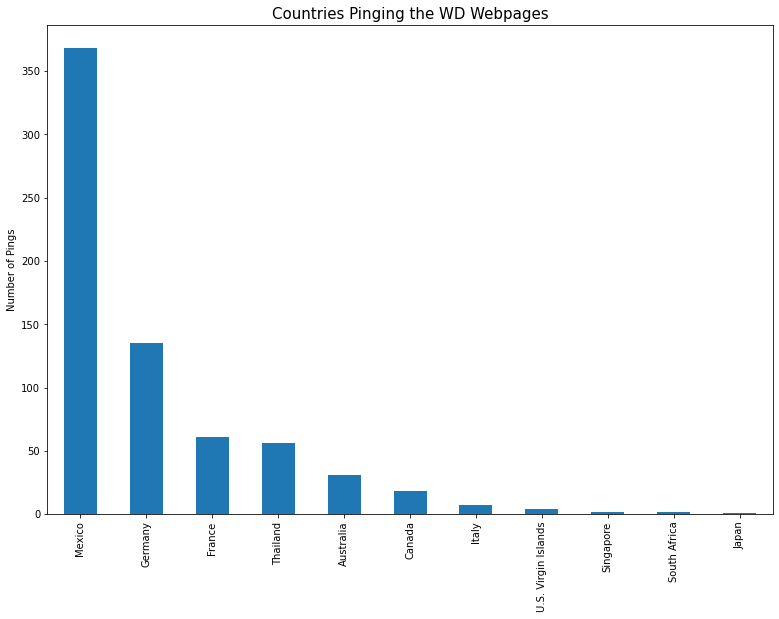

In [660]:
wd_foreign_ip = wd_df[wd_df.country_name != 'United States']
wd_foreign_ip.country_name.value_counts().plot(kind = 'bar', figsize = (13, 9))
plt.title("Countries Pinging the WD Webpages", fontsize = 15)
plt.ylabel("Number of Pings")
plt.show()

#### Takeaway:
- There are quite a large number of foreign IPs accessing the webdev curriculum.
- Again this could be students using a VPN, but more work is needed to isolate and discover what pages (and the number of total pages) that each of these users were accessing.


### 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 

In [522]:
ds_df.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True


In [531]:
ds_df.webpage.isna().sum()

1

In [533]:
ds_df = ds_df.dropna()

In [565]:
duplicate_ds_mask = ds_df.webpage.str.contains('java|html-css|jQuery|spring|tdd')

In [572]:
duplicate_ds_mask.value_counts()

False    52850
True        66
Name: webpage, dtype: int64

In [566]:
ds_df_dup = ds_df[duplicate_ds_mask]
ds_df_dup

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds
date_time,,,,,,,,,,
2019-09-23 11:45:09,java-iii,476,34.0,97.105.19.58,2019,9,23,11,Monday,True
2019-09-25 19:30:42,html-css,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:30:44,javascript-i,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:30:49,html-css,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:31:07,javascript-i,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:31:11,java-i,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:31:12,javascript-i,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:31:14,java-i,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True
2019-09-25 19:31:19,java-ii,476,34.0,136.50.49.145,2019,9,25,19,Wednesday,True


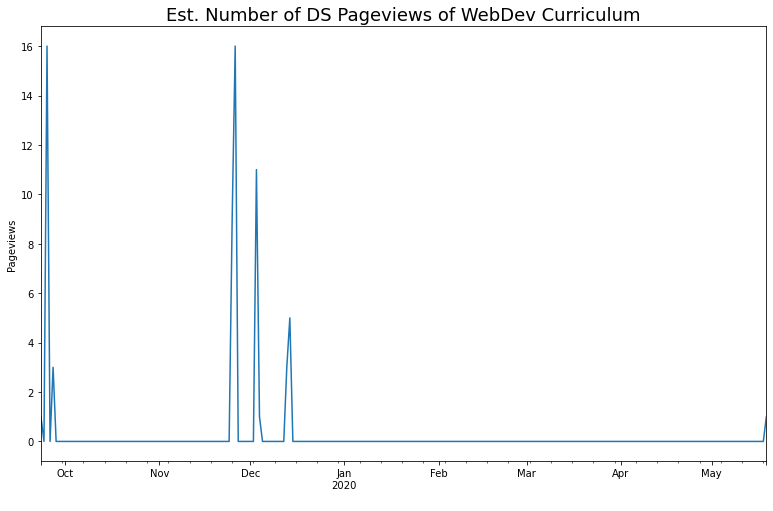

In [597]:
ds_df_dup.resample("D").webpage.count().plot(figsize = (13, 8))
plt.title("Est. Number of DS Pageviews of WebDev Curriculum", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Pageviews")
plt.show()

#### Takeaway:

- It appears that all DS student access to the webdev curriculum was cut off around the end of 2019. However, several pings to the webdev classwork can be seen at the end of May 2020.

In [609]:
wd_df2 = df.copy()

In [610]:
(wd_df2.cohort_id == 59.0).value_counts()

False    697034
True      22425
Name: cohort_id, dtype: int64

In [612]:
wd_df2.shape

(719459, 11)

In [613]:
# Isolating only the webdev stuff.
wd_df2 = wd_df2[~wd_df2.cohort_id.isin([30, 34, 55, 59])]
wd_df2.shape


(651442, 11)

In [618]:
duplicate_wd_mask = wd_df2.webpage.str.contains('regression|classification|python|stats')
duplicate_wd_mask.value_counts()
wd_dup = wd_df2[duplicate_wd_mask]

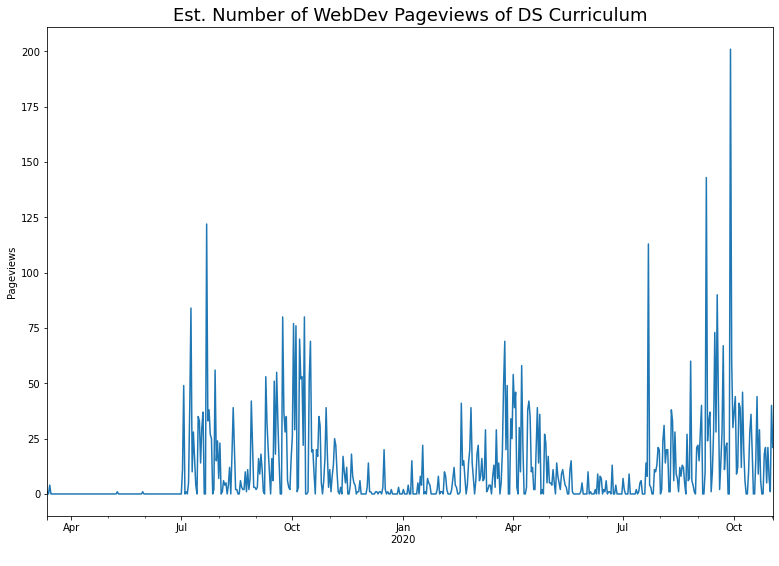

In [619]:
wd_dup.resample("D").webpage.count().plot(figsize = (13, 9))
plt.title("Est. Number of WebDev Pageviews of DS Curriculum", fontsize = 18)
plt.xlabel(" ")
plt.ylabel("Pageviews")
plt.show()

#### Takeaways:

- It appears that DS students did not or were not able to view the webdev curriculum after Jan 2020.
- Webdev students appear to have been able to view the curriculum since July 2019, but do not appear to have pinged the curriculum nearly at all prior to that date.

### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

In [431]:
# Need to find the end date of each cohort, and then figure out which cohort_id is accessing the content (any page hit) after that date. I could use a boolean mask probably.

### Data Science

In [508]:
ds_merged.head()

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active,log_date
date,,,,,,,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:40:28
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:40:30
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:41:02
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:41:28
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34.0,97.105.19.58,2019,8,20,9,Tuesday,True,Bayes,2019-08-19,2020-01-30,3,True,2019-08-20 09:41:36


In [439]:
# ds_merged['access_post_class'] = 
ds_merged['log_date'] = ds_merged.index

In [442]:
post_class_ds = ds_merged[ds_merged.log_date > ds_merged.end_date]

In [509]:
ds_merged.shape, post_class_ds.shape

((52917, 16), (4164, 16))

Goal is to find the kind of lessons that were accessed after class.

In [459]:
post_class_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4164 entries, 2020-01-30 08:01:31 to 2020-11-02 15:33:27
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   webpage     4164 non-null   object        
 1   user_id     4164 non-null   int64         
 2   cohort_id   4164 non-null   float64       
 3   ip          4164 non-null   object        
 4   year        4164 non-null   int64         
 5   month       4164 non-null   int64         
 6   day         4164 non-null   int64         
 7   hour        4164 non-null   int64         
 8   weekday     4164 non-null   object        
 9   is_ds       4164 non-null   bool          
 10  name        4164 non-null   object        
 11  start_date  4164 non-null   datetime64[ns]
 12  end_date    4164 non-null   datetime64[ns]
 13  program_id  4164 non-null   int64         
 14  is_active   4164 non-null   bool          
 15  log_date    4164 non-null   datetime

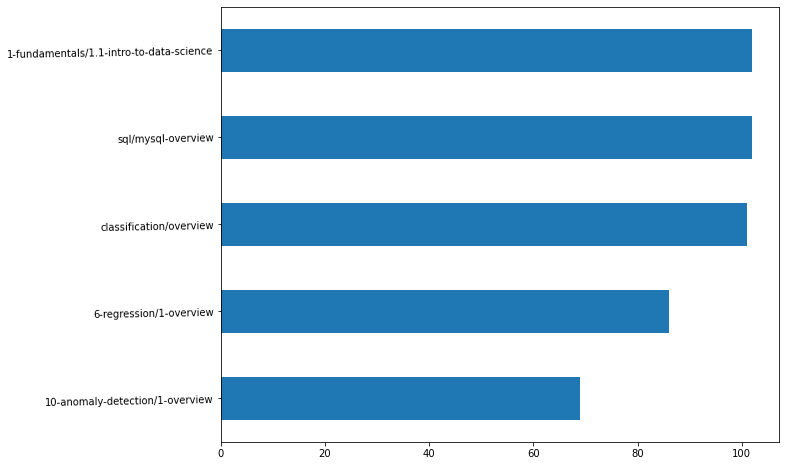

In [670]:
post_class_ds.webpage.value_counts().head(5).plot(kind = 'barh', rot = 1, figsize = (10, 8))
# plt.xticks(rotation = 90)
plt.gca().invert_yaxis()
plt.show()

#### Takeaways:

The top 5 pages accessed after a DS cohort graduated thus far are:
1. Fundamentals/Intro to data science
2. MySQL overview
3. Classification overview
4. Regression Overview
5. Anomaly Detection Overview

### Webdev

In [507]:
# Creating a dataframe that only includes webdev cohorts, and also includes the start and end date of each cohort.
# In this way, I can isolate rows (webpage views) that have occured after a cohort graduates. The beauty of this is, because I'm using a boolean mask, I don't have to drill down by cohort, all I have to do 

wd_merged = df_merge2[~df_merge2.cohort_id.isin([30, 34, 55, 59])]

In [511]:
wd_merged['log_date'] = wd_merged.index

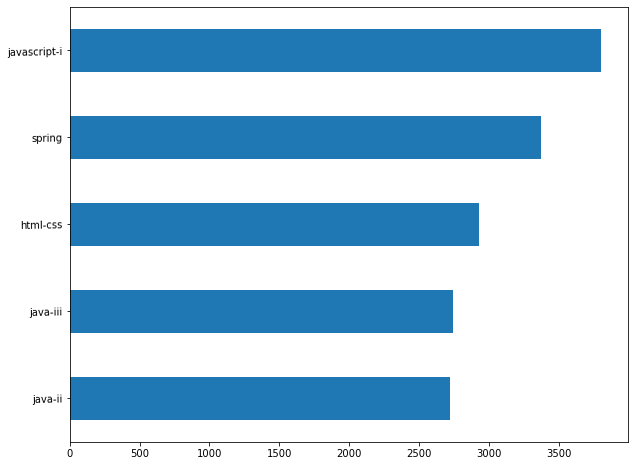

In [671]:
post_class_wd = wd_merged[wd_merged.log_date > wd_merged.end_date]
post_class_wd.webpage.value_counts().head(5).plot(kind = 'barh', rot = 1, figsize = (10, 8))
# plt.xticks(rotation = 90)
plt.gca().invert_yaxis()
plt.show()

#### Takeaways:

The top 5 pages accessed after a webdev cohort graduated thus far are:
1. javascript-i
2. spring
3. html-css
4. java-iii
5. java-ii

### 7. Which lessons are least accessed?

In [413]:
df_merge2 = df_merge2[df_merge2.webpage != "/"]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("github.com") != True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("jpeg")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("jpg")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("svg")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("toc")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains(".gitignore")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains(".git")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("json")!= True]
df_merge2 = df_merge2[df_merge2.webpage.str.contains("wp-login")!= True]
df_merge2

,webpage,user_id,cohort_id,ip,year,month,day,hour,weekday,is_ds,name,start_date,end_date,program_id,is_active
date,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018,1,26,9,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 10:40:15,javascript-i/functions,1,8.0,97.105.19.61,2018,1,26,10,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
2018-01-26 11:26:13,java-i,1,8.0,97.105.19.61,2018,1,26,11,Friday,False,Hampton,2015-09-22,2016-02-06,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62.0,107.192.148.199,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True
2020-11-02 16:48:18,javascript-i/coffee-project,771,62.0,172.125.226.175,2020,11,2,16,Monday,False,Jupiter,2020-09-21,2021-03-30,2,True


In [415]:
ds_merged = df_merge2[df_merge2.cohort_id.isin([30, 34, 55, 59])]

In [416]:
# pd.DataFrame(ds_df.webpage.value_counts()) < 2

pcounts = pd.DataFrame(ds_merged.webpage.value_counts())

In [417]:
low_counts = pcounts[pcounts.webpage < 2]

In [514]:
low_counts.shape

(76, 1)

In [515]:
low_counts.sort_index()

,webpage
10-anomaly-detection/3-discrete-probabilistic-methods.ipynb,1
12-distributed-ml/3-getting-started,1
12-distributed-ml/4-acquire,1
12-distributed-ml/5-inspect,1
12-distributed-ml/6.1-prepare-part-1,1
12-distributed-ml/6.2-prepare-part-2,1
12-distributed-ml/6.3-prepare-part-3,1
12-distributed-ml/6.4-prepare-part-4,1
12-distributed-ml/8.1-classification,1
12-distributed-ml/spark-topics,1


In [406]:
pd.options.display.max_rows
# Intially set at 60 by default.
pd.options.display.max_rows = 80


#### Takeaways:

- There are 76 webpages in the data science curriculum that have only been accessed 1 time since 2018. 
- If there were more time, I'd want to compare each single entry to the last time it was accesses in the log.
- A few of the single pageview webpages appear to be webdev content, so there could be some "corruption" of when cohorts were allowed to see other program's curriculum, and only viewed an opposite program's pages once.

**In Summary; either the lesson summaries were only needed to be read once, or the lesson wasn't particularly useful to the students.**

### Webdev Cohorts

In [422]:
wd_merged = df_merge2[~df_merge2.cohort_id.isin([30, 34, 55, 59])]

In [622]:
wd_pcounts = pd.DataFrame(wd_merged.webpage.value_counts())
wd_low_counts = wd_pcounts[wd_pcounts.webpage < 2]
wd_low_counts.shape

(396, 1)

In [628]:
wd_low_counts

,webpage
student/120,1
css-ii/grids,1
1._Fundamentals/index.html,1
capstone/55,1
data-1,1
...,...
sequel-pro,1
12-distributed-ml/topic-modeling,1
12-distributed-ml/read-jdbc,1
7_DBSCAN,1


#### Takeaways:

- There are 396 webpages within the webdev cohorts that were viewed exactly 1 time. This could include several data science curriculum pages, thus some of the pages in this dataframe and the DS dataframe above could be duplicated.
- Next step is to compare the IP addresses of the DS and WD dataframe and see if they are identical, or have the same `user_id`

## Conclusions


- Question 1:


- Question 2:


- Question 3:


- Question 4:


- Question 5:


- Question 6:


- Question 7:
#### Takeaways:

    - There are 76 webpages in the data science curriculum that have only been accessed 1 time since 2018. 
    - If there were more time, I'd want to compare each single entry to the last time it was accesses in the log.
    - A few of the single pageview webpages appear to be webdev content, so there could be some "corruption" of when cohorts were allowed to see other program's curriculum, and only viewed an opposite program's pages once.
    - There are 396 webpages within the webdev cohorts that were viewed exactly 1 time. This could include several data science curriculum pages, thus some of the pages in this dataframe and the DS dataframe above could be duplicated.
    - Next step is to compare the IP addresses of the DS and WD dataframe and see if they are identical, or have the same `user_id`

    **In Summary; either the lesson summaries were only needed to be read once, or the lesson wasn't particularly useful to the students.**


- Question 8:
     - One thing to consider is that we are limited in our data. For example, the data science cohort Ada isn't represented in our dataset here at all. This may have more of an impact related to which lessons are most accessed lessons or lessons accessed after gradudation than the other questions raised, but it is important to note that some DS and webdev cohorts are not represented at all in the data.

